# US Energy Sources

In this lesson we will learn how to extract geospatial data from a CSV to create a `geopandas.GeoDataFrame` and go over some more customizations for maps and matplotlib figures.

## About the data

The U.S. energy landscape relies on a mix of fossil fuels and renewables, each with unique environmental and economic impacts. As the nation works toward sustainability and energy security, understanding this energy mix is essential for informed policy and progress toward cleaner energy.

In this lesson, we will use data from the U.S. Energy Information Administration (EIA) about operable electric generating plants in the United States by energy source, as of May 2023. The dataset includes information on plant types and energy sources, offering insights into the diversity of power sources—from fossil fuels to renewables—that supply electricity nationwide. The dataset’s metadata can be accessed here The EIA data on electric plants has been downloaded as a CSV and reprojected into the EPSG:4269 CRS for this lesson. It can be accessed here.

Additionally, we will use a TIGER shapefile of the US states from the United States Census Bureau. TIGER stands for Topologically Integrated Geographic Encoding and Referencing. This used to be the data format the US Census distributed geospatial data, but since 2008 TIGER files are converted to shapefiles.

Follow these steps to download shapefile with the United States’ states:

1. At the bottom of the 2022 page, under Download, click on “Web Interface”
2. For year, select 2022, and for layer type select “States (and equivalent)”. Click submit.
3. Click on “Download national file”.

## CSV to `geopandas.GeoDataFrame`

Let’s start by importing packages and updating viewing options:

In [1]:
import os

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import geopandas as gpd
import matplotlib.pyplot as plt

# Display all columns when looking at dataframes
pd.set_option("display.max.columns", None)

Next, we import the power plants dataset. In this lesson, we have downloaded the data into a `data/` folder in the same level as our notebook.

In [2]:
# Import power plants data
URL = 'https://raw.githubusercontent.com/carmengg/eds-220-book/refs/heads/main/data/power_plants_epsg4269.csv'
power_plants = pd.read_csv(URL)

# Simpify column names
power_plants.columns = power_plants.columns.str.lower()

power_plants.head(3)

,unnamed: 0,objectid,plant_code,plant_name,utility_id,utility_name,sector_name,street_address,city,county,state,zip,primsource,source_desc,tech_desc,install_mw,total_mw,bat_mw,bio_mw,coal_mw,geo_mw,hydro_mw,hydrops_mw,ng_mw,nuclear_mw,crude_mw,solar_mw,wind_mw,other_mw,source,period,longitude,latitude
0,0.0,11570,1,Sand Point,63560,"TDX Sand Point Generating, LLC",Electric Utility,100 Power Plant Way,Sand Point,Aleutians East,Alaska,99661.0,petroleum,"Petroleum = 1.3 MW, Wind = 0.4 MW",Petroleum Liquids; Onshore Wind Turbine;,3.7,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,0.4,NaN,"EIA-860, EIA-860M and EIA-923",202305.0,-160.497222,55.339722
1,1.0,11571,2,Bankhead Dam,195,Alabama Power Co,Electric Utility,19001 Lock 17 Road,Northport,Tuscaloosa,Alabama,35476.0,hydroelectric,Hydroelectric = 53 MW,Conventional Hydroelectric,53.9,53.0,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"EIA-860, EIA-860M and EIA-923",202305.0,-87.356823,33.458665
2,2.0,11572,3,Barry,195,Alabama Power Co,Electric Utility,North Highway 43,Bucks,Mobile,Alabama,36512.0,natural gas,"Coal = 1118.5 MW, Natural Gas = 1296.2 MW",Conventional Steam Coal; Natural Gas Fired Com...,2569.5,2414.7,NaN,NaN,1118.5,NaN,NaN,NaN,1296.2,NaN,NaN,NaN,NaN,NaN,"EIA-860, EIA-860M and EIA-923",202305.0,-88.010300,31.006900


The power plants file is a CSV. Unlike shapefiles or other geospatial file formats, `geopandas` doesn’t have a way to extract a geometry column from a CSV file, so we will need to create this geometry manually.

To do so we will use the longitude and latitude columns in the CSV, these indicate the location of the power plants in the NAD83 CRS (EPSG:4269). We can use this information to create a new `geopandas.GeoDataFrame` from the `pandas.DataFrame` using the `geopandas` function `points_from_xy()`:

In [3]:
# Create points from latitude and longitude
points = gpd.points_from_xy(power_plants.longitude, 
                            power_plants.latitude)

# Create geodataframe
power_plants = gpd.GeoDataFrame(power_plants,    # Data
                                geometry=points, # Specify geometry column
                                crs='EPSG:4269'  # Specify CRS
                               )

Let's check that we now have a geometry column:

In [4]:
power_plants['geometry']

0        POINT (-160.49722 55.33972)
1         POINT (-87.35682 33.45867)
2         POINT (-88.01030 31.00690)
3         POINT (-86.28306 32.58389)
4        POINT (-106.37500 31.75690)
                    ...             
12004     POINT (-82.37595 35.38014)
12005     POINT (-79.36770 36.00932)
12006     POINT (-79.73631 35.27343)
12007     POINT (-73.91048 42.87657)
12008     POINT (-77.27590 41.83800)
Name: geometry, Length: 12009, dtype: geometry

We can now also access information about the CRS of our power plants dataset:

In [5]:
# Explore CRS
print('CRS: ', power_plants.crs)
print('ellipsoid: ', power_plants.crs.ellipsoid)
print('datum: ', power_plants.crs.datum)
print('is the CRS geographic?: ', power_plants.crs.is_geographic)
print('is the CRS projected?: ', power_plants.crs.is_projected)

CRS:  EPSG:4269
ellipsoid:  GRS 1980
datum:  North American Datum 1983
is the CRS geographic?:  True
is the CRS projected?:  False


With the geometry column and CRS, we can plot our dataset:

<AxesSubplot:>

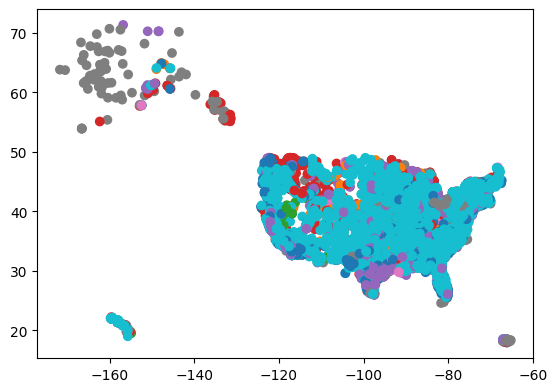

In [6]:
# Plot points and color them according to values in primsource column
power_plants.plot(column='primsource')  

## Import shapefile

Let's import the TIGER shapefile

In [8]:
# Import states data
fp = os.path.join('data','tl_2022_us_state','tl_2022_us_state.shp')
states = gpd.read_file(fp)

# Simplify column names 
states.columns = states.columns.str.lower()

states.head(3)

,region,division,statefp,statens,geoid,stusps,name,lsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266456923,489045863,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138962819934,45971472526,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778515726,6216539665,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."


epsg:4269


/opt/python/3.7.13/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

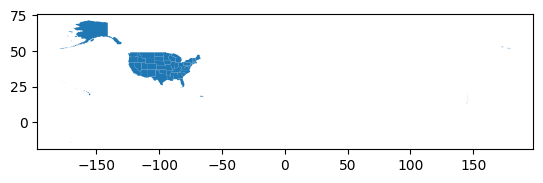

In [9]:
# Obtain some preliminary geospatial information about the states geodataframe:
print(states.crs)
states.plot()

# `for` loops

It can be easier to work with the codes as numbers instead of strings, so let’s update the corresponding columns in the states geo-dataframe. We start by checking the data type of the `region`, `division`, and `statefp` columns:

In [11]:
print(f"region is string dtype? {is_string_dtype(states['region'])}")
print(f"region is string dtype? {is_string_dtype(states['division'])}")
print(f"region is string dtype? {is_string_dtype(states['statefp'])}")

region is string dtype? True
region is string dtype? True
region is string dtype? True


This is a correct way of coding for this information. However, this is inconvenient as it repeats the same pieces of code, only changing the column name. Instead, using the for loop allows us to succintly print the same information:

In [12]:
 code_cols = ['region', 'division', 'statefp']

# Check whether codes columns are strings
 for column in code_cols: 
    print(f"{column} is string dtype? {is_string_dtype(states[column])}")

region is string dtype? True
division is string dtype? True
statefp is string dtype? True


Don’t Repeat Yourself (DRY) is a core programming principle that encourages reducing redundancy and consolidating repeated logic. Try implementing it as much as possible! If you need to repeat the “same” code more than twice, you likely need a for loop.

Next, we update the data type of the code columns to be integers. This time, we check the data type of the column using the `is_numeric_dtype()` function inside an **`assert`** statement:

In [13]:
# Update code columns into integers
for column in code_cols:
    states[column] = states[column].astype('int')
    assert is_numeric_dtype(states[column])  # Check conversion

The `assert` keyword does nothing if the expression next to it evaluates to `True` and raises an `AssertionError` exception and stops your code form running any further. For example,

In [14]:
# Does nothing if statement is True
assert 2+2 == 4

In [15]:
# Raises an error if statement is False
assert 2+2 == 3

AssertionError: 

In our data type conversion code, since no `AssertionError` was raised, we can be confident that the data type was updated.

## Data selection
For this lesson, we want to use only the contiguous states. As seen in the plot, the data covers a bigger extension.

#### Check-in

From the TIGER shapefiles metadata we know that:

"In addition to the fifty states, the Census Bureau treats the District of Columbia, Puerto Rico, and the Island areas (American Samoa, the Commonwealth of the Northern Mariana Islands, Guam, and the U.S. Virgin Islands) as statistical equivalents of states for the purpose of data presentation."

In this US Census Bureau file we can see what each code for the region, division, and state corresponds to.

- What are the unique values for region, division, or state codes in the data?

- Which codes should should we select to keep only states in the contiguous US?

In [16]:
states.region.unique()

array([3, 2, 1, 4, 9])

In [17]:
states.division.unique()

array([5, 3, 4, 1, 8, 9, 2, 7, 6, 0])

In [18]:
states.statefp.unique()

array([54, 12, 17, 27, 24, 44, 16, 33, 37, 50,  9, 10, 35,  6, 34, 55, 41,
       31, 42, 53, 22, 13,  1, 49, 39, 48,  8, 45, 40, 47, 56, 15, 38, 21,
       78, 69, 66, 23, 36, 32,  2, 60, 26,  5, 28, 29, 30, 20, 18, 72, 46,
       25, 51, 11, 19,  4])

Hawaii and Alaska have codes 2, 15, and then region 9 should also be excluded.

In [22]:
# Select contiguous US states
contiguous = states[(states.region!=9) & (~states.statefp.isin([2,15]))]

In this code we used the syntax:

```python
~df.column.isin([val1, val2, val3])
```
The `~` tilde symbol is used in Python to negate a statement. So the previous line could be read as “the values in `df`’s column which are not in the list ``[val1, val2, val3]``.”

/opt/python/3.7.13/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

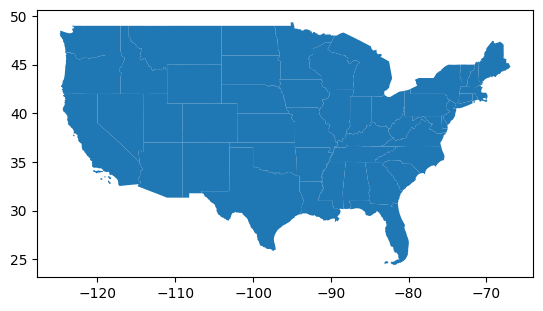

In [24]:
contiguous.plot()

#### Check-in 
Select the data in the `power_plants` data frame for the contiguous US states.

In [25]:
power_plants = power_plants[~power_plants.state.isin(['Puerto Rico', 'Hawaii', 'Alaska'])]

## Plotting

Before we plot our data, let’s make sure they are in the same CRS:

In [26]:
contiguous.crs == power_plants.crs

True

/opt/python/3.7.13/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:title={'center':'Operable electric generating plants in the contiguous United States'}>

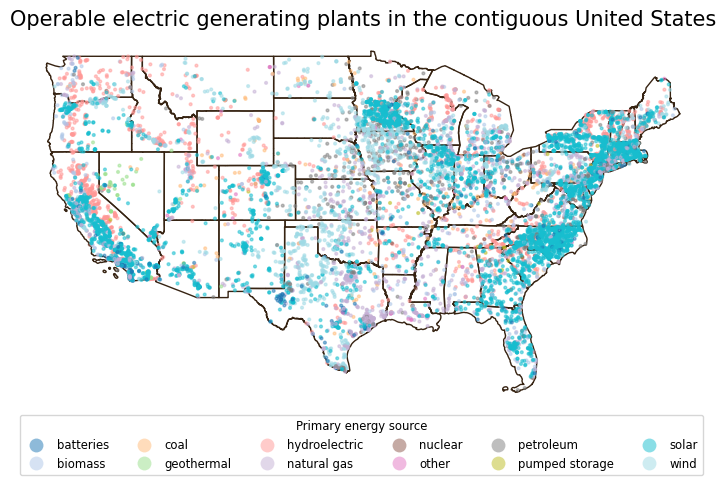

In [35]:
fig, ax = plt.subplots(figsize=(9,5))

# remove the axis for a cleaner map
ax.axis('off')

# Title for the plot
ax.set_title('Operable electric generating plants in the contiguous United States',
             fontsize = 15)

# Add states
contiguous.plot(ax=ax,
                color='none',
                edgecolor='#362312')

# Add electric power plants colored by energy source
power_plants.plot(ax=ax,
                 column='primsource',
                 legend=True,
                 markersize=4,
                 cmap='tab20',
                 alpha=0.5,
                 legend_kwds={
                     'title': 'Primary energy source',
                     'title_fontsize': 'small',
                     'fontsize': 'small',
                     'loc': 'upper left',
                     'bbox_to_anchor': (0, 0),
                     'ncol': 6
                 })

In the map above we specified the figure size when creating the plot. This size is given in inches, but can be updated to other units (pixels, cm, etc).

We also controlled the legend location using `loc` and `bbox_to_anchor` in the `legend_kwds`:

- `loc` indicates the corner of the legend we want to use for placement, and
- `bbox_to_anchor` is a tuple with coordinates indicating where to place the corner specified in `loc` relative to the axes. Values between 0 and 1 are within the axes.

`matplotlib` uses a variety of ways to locate elements within the graph and it is best to check the documentation to not spend too much time fidling with locations.

## `for` with `zip`

Often, we need to iterate simultaneously over two iterables. The `zip()` function in Python allows you to combine two or more lists (or other iterables) so that you can iterate over their elements in pairs. When used with a `for` loop, it lets you process elements from each list together, like this example:

In [37]:
# Iterate over a single list
numbers = [1, 2, 3]
for num in numbers:
    print(num)
    
print('\n') # Blank line

# Iterate over two lists in pairs using zip()
letters = ['a', 'b', 'c']
for num, letter in zip(numbers, letters):
    print(num, letter)

1
2
3


1 a
2 b
3 c


A common situation when code gets repeated is when creating subplots. For example:

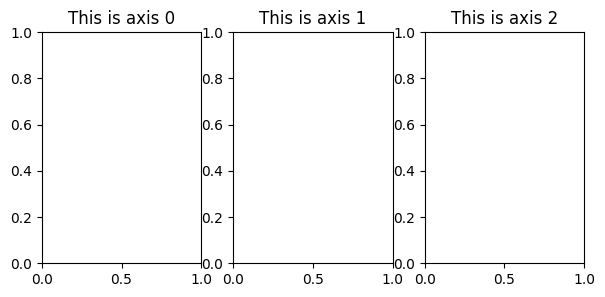

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 3))

axes[0].set_title('This is axis 0')
axes[1].set_title('This is axis 1')
axes[2].set_title('This is axis 2')

plt.show()

In this example, notice that the axes variable returend by the `plt.subplots()` function is actually a list of axes we can iterate over.

#### Check-in
Use for and zip() to create the same subplots and avoid redundancy.

In [39]:
plot = [1, 2, 3]
for num, letter in zip(numbers, letters):
    plt.subplots(nrows=1, ncols=3, figsize=(7, 3)
    axes[plot].set_title('This is axis', plot)

SyntaxError: invalid syntax (3539361655.py, line 4)